In [49]:
# Based on Erik's script: plotting_NEMO.ipynb
%pylab inline
import numpy as np
import xarray as xr
import pandas as pd
import matplotlib.pyplot as plt
import cartopy
from cartopy.mpl.gridliner import LONGITUDE_FORMATTER, LATITUDE_FORMATTER
from cartopy.util import add_cyclic_point
import matplotlib.colors as colors
#import matplotlib.gridspec as gridspec
import matplotlib.patches as mpatches
import matplotlib.path as mpath
import matplotlib.ticker as mticker
from matplotlib.patches import Polygon, Ellipse
from glob import glob
import cmocean.cm as cmo
import gsw
import pickle

# from matplotlib.axes import Axes
# from cartopy.mpl.geoaxes import GeoAxes
# GeoAxes._pcolormesh_patched = Axes.pcolormesh

#import warnings
#warnings.filterwarnings("ignore", category=RuntimeWarning)
#warnings.filterwarnings("ignore", category=UserWarning)

Populating the interactive namespace from numpy and matplotlib


In [50]:
savefig = False #True
figext = '.pdf'
    
degsym = u'\u00B0'

def savefig(fignum, figext=figext, savefig=savefig):
    figname = 'Figures/Fig%s%s' % (figname, figext)
    if savefig:
        plt.savefig(figname)

In [51]:
datadir = '/projects/0/topios/hydrodynamic_data/NEMO-MEDUSA/ORCA0083-N006/means/'
datadir_bgc = '/projects/0/topios/hydrodynamic_data/NEMO-MEDUSA_BGC/ORCA0083-N006/means/' 
dirread_mesh = '/projects/0/topios/hydrodynamic_data/NEMO-MEDUSA/ORCA0083-N006/domain/' 

xslice = slice(0, 4300)
yslice = slice(0, 3057)
nav_lon = xr.open_dataset(dirread_mesh+'coordinates.nc',decode_times=False).nav_lon.sel(x=xslice,y = yslice) 
nav_lat = xr.open_dataset(dirread_mesh+'coordinates.nc',decode_times=False).nav_lat.sel(x=xslice,y = yslice) 
nav_lat = nav_lat.fillna(0.)

''' Shifting longitude to be continuously increasing ''' 
#lon_shift = np.zeros((len(nav_lat[:,0]),len(nav_lat[0,:])))
for ii in range(len(nav_lon[:,0])):
    f = nav_lon[ii,0]
    lon1 = nav_lon[ii,:]
    ind = np.where(lon1>=f)[0]
    #lon_shift[ii,:] = nav_lon[ii,:]
    nav_lon[ii,ind] = nav_lon[ii,ind]-360

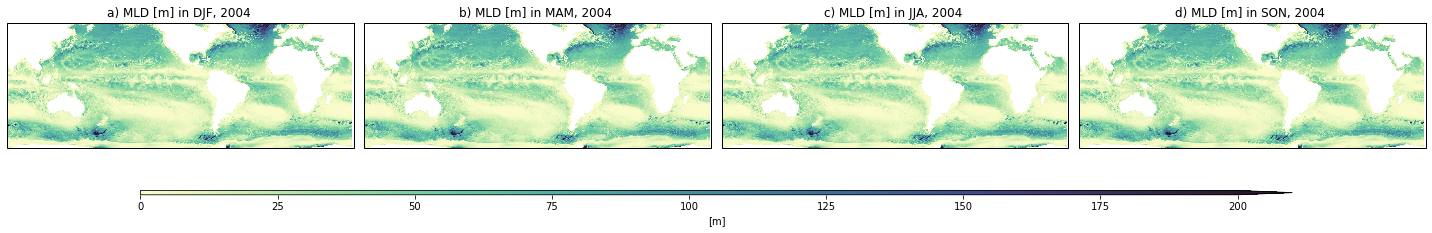

In [52]:
''' Preparing the projection and subplots'''
projection = cartopy.crs.Robinson() #central_longitude=0) #PlateCarree() #central_longitude=0)
fig = plt.figure(figsize=(20, 4), constrained_layout=True) # 10,5
gs = fig.add_gridspec(figure = fig, nrows = 1, ncols = 4) #, height_ratios=[1, 1]) # gridspec.GridSpec

''' Extract all files within a season into one variable '''

seasnames = ['DJF', 'MAM', 'JJA', 'SON']
monvals = ['12','01','02','03','04','05','06','07','08','09','10','11']
#filenames = ['D','P']
#for row in range(1):
for col in range(4):
    i = col #row*4 + col
    #file = filenames[row]
    seas = seasnames[col]
    yr0 = '2004'
    yr1 = '2004'

    ai = fig.add_subplot(gs[0, col], projection=projection)
    ai.coastlines(resolution='50m',zorder=3)
    ai.add_feature(cartopy.feature.LAND, zorder=2)
    ai.set_ylim([-70, 60]) #,crs=cartopy.crs.PlateCarree())

#         if col == 0: 
#             yr0 = '2003'
#             mons = monvals[0:3]
#         if col == 1: 
#             mons = monvals[3:6]
#         if col == 2: 
#             mons = monvals[6:9]
#         if col == 3: 
#             mons = monvals[9:12]

    #if i < 4:           
    M = xr.open_dataset(datadir+'ORCA0083-N06_20031201d05T.nc').mldr10_1.sel(x=xslice,y = yslice)#.mean('time_counter')     
    M = M.assign_coords(nav_lon=nav_lon)
    M = M.assign_coords(nav_lat=nav_lat)
    
    a = M.plot(ax=ai, x='nav_lon', y='nav_lat', add_colorbar=False, vmin=0, vmax=200, rasterized=True, cmap=cmo.deep, zorder = 1) #, transform=cartopy.crs.PlateCarree()) 
    title = 'MLD [m] in %s, 2004' % seas

# for row in range(2):
#     for col in range(4):

#         if i > 3:           
#             M1 = xr.open_dataset(datadir_bgc+'ORCA0083-N06_20031201d05P.nc').PHD.sel(x=xslice,y = yslice)#.mean('time_counter')

#             M2 = xr.open_dataset(datadir_bgc+'ORCA0083-N06_20031201d05P.nc').PHN.sel(x=xslice,y = yslice)#.mean('time_counter') 
#             M = M1[0,0,:,:]+M2[0,0,:,:] 
#             M = M.assign_coords(nav_lon=nav_lon)
#             M = M.assign_coords(nav_lat=nav_lat)

#             a2 = plt.plot(p,p)
#             #a2 = M.plot(ax=ai, x='nav_lon', y='nav_lat', add_colorbar=False, vmin=0, vmax=25, rasterized=True, cmap=cmo.deep, zorder = 1) #, transform=cartopy.crs.PlateCarree()) 
#             title = 'Phytoplankton conc in %s, 2004' % seas

    ai.set_title('%s) %s ' % (chr(ord('a') + row*4 + col), title))

   # plt.title('Average mixed layer depth in Jan 2004')

cbaxes = fig.add_axes([0.1, 0.12, 0.8, 0.015]) # defines the x, y, w, h of the colorbar 
plt.colorbar(a, cax=cbaxes, orientation="horizontal", aspect=100, extend='max', label='[m]')#, use_gridspec=True)

# cbaxes2 = fig.add_axes([0.1, 0.12, 0.8, 0.015]) # defines the x, y, w, h of the colorbar 
# plt.colorbar(a2, cax=cbaxes2, orientation="horizontal", aspect=100, extend='max', label='[m]', use_gridspec=True)

fig.canvas.draw()
plt.tight_layout()
# savefig(fignum)

In [ ]:
## To plot the MLD and phytoplankton subplots in one figure 

''' Preparing the projection and subplots'''
projection = cartopy.crs.Robinson(central_longitude=0) #PlateCarree() #central_longitude=0)
fig = plt.figure(figsize=(15, 10), constrained_layout=True) # 10,5
gs = fig.add_gridspec(3, 4, height_ratios=[10, 10, 1.5]) # 5, 5, 1.5

''' Extract all files within a season into one variable '''

seasnames = ['DJF', 'MAM', 'JJA', 'SON']
monvals = ['12','01','02','03','04','05','06','07','08','09','10','11']
#filenames = ['D','P']
for row in range(2):
    for col in range(4):
        i = row*4 + col
        #file = filenames[row]
        seas = seasnames[col]
        yr0 = '2004'
        yr1 = '2004'
        
        ai = fig.add_subplot(gs[row, col], projection=projection)
        ai.coastlines(resolution='50m',zorder=3)
        ai.add_feature(cartopy.feature.LAND, zorder=2)
        ai.set_ylim([-70, 60]) #,crs=cartopy.crs.PlateCarree())
        
        if col == 0: 
            yr0 = '2003'
            mons = monvals[0:3]
        if col == 1: 
            mons = monvals[3:6]
        if col == 2: 
            mons = monvals[6:9]
        if col == 3: 
            mons = monvals[9:12]

        if i < 4:           
            M = xr.open_mfdataset((glob(datadir+'ORCA0083-N06_%s%s*d05T.nc' % (yr0,mons[0]) )+ glob(datadir+'ORCA0083-N06_%s%s*d05T.nc' % (yr1,mons[1]))+ 
                                          glob(datadir+'ORCA0083-N06_%s%s*d05T.nc'% (yr1,mons[2]))),combine='by_coords').mldr10_1.sel(x=xslice,y = yslice).mean('time_counter')     
            M = M.assign_coords(nav_lon=nav_lon)
            M = M.assign_coords(nav_lat=nav_lat)

            a = M.plot(ax=ai, x='nav_lon', y='nav_lat', add_colorbar=False, vmin=0, vmax=200, rasterized=True, cmap=cmo.deep, zorder = 1) #, transform=cartopy.crs.PlateCarree()) 
            title = 'MLD [m] in %s, 2004' % seas
            
        if i > 3:           
            M1 = xr.open_mfdataset((glob(datadir_bgc+'ORCA0083-N06_%s%s*d05P.nc' % (yr0,mons[0]) )+ glob(datadir_bgc+'ORCA0083-N06_%s%s*d05P.nc' % (yr1,mons[1]))+ 
                                          glob(datadir_bgc+'ORCA0083-N06_%s%s*d05P.nc'% (yr1,mons[2]))),combine='by_coords').PHD.sel(x=xslice,y = yslice).mean('time_counter')
            
            M2 = xr.open_mfdataset((glob(datadir_bgc+'ORCA0083-N06_%s%s*d05P.nc' % (yr0,mons[0]) )+ glob(datadir_bgc+'ORCA0083-N06_%s%s*d05P.nc' % (yr1,mons[1]))+ 
                                          glob(datadir_bgc+'ORCA0083-N06_%s%s*d05P.nc'% (yr1,mons[2]))),combine='by_coords').PHN.sel(x=xslice,y = yslice).mean('time_counter') 
            M = M1+M2
            M = M.assign_coords(nav_lon=nav_lon)
            M = M.assign_coords(nav_lat=nav_lat)

            a = M.plot(ax=ai, x='nav_lon', y='nav_lat', add_colorbar=False, vmin=0, vmax=200, rasterized=True, cmap=cmo.deep, zorder = 1) #, transform=cartopy.crs.PlateCarree()) 
            title = 'Phytoplankton conc in %s, 2004' % seas
#         if i == 0:           
#             M = xr.open_mfdataset((glob(datadir+'ORCA0083-N06_200312*d05T.nc')+ glob(datadir+'ORCA0083-N06_200401*d05T.nc')+ 
#                                           glob(datadir+'ORCA0083-N06_200402*d05T.nc')),combine='by_coords').mldr10_1.sel(x=xslice,y = yslice).mean('time_counter')
#         if i == 1:
#             M = xr.open_mfdataset((glob(datadir+'ORCA0083-N06_200403*d05T.nc')+ glob(datadir+'ORCA0083-N06_200405*d05T.nc')+ 
#                                           glob(datadir+'ORCA0083-N06_200406*d05T.nc')),combine='by_coords').mldr10_1.sel(x=xslice,y = yslice).mean('time_counter')
#         if i == 2:
#             M = xr.open_mfdataset((glob(datadir+'ORCA0083-N06_200407*d05T.nc')+ glob(datadir+'ORCA0083-N06_200408*d05T.nc')+ 
#                                           glob(datadir+'ORCA0083-N06_200408*d05T.nc')),combine='by_coords').mldr10_1.sel(x=xslice,y = yslice).mean('time_counter')
#         if i == 3:
#             M = xr.open_mfdataset((glob(datadir+'ORCA0083-N06_200409*d05T.nc')+ glob(datadir+'ORCA0083-N06_200410*d05T.nc')+ 
#                                           glob(datadir+'ORCA0083-N06_200411*d05T.nc')),combine='by_coords').mldr10_1.sel(x=xslice,y = yslice).mean('time_counter')
            
#         if i == 4:           
#             M = xr.open_mfdataset((glob(datadir+'ORCA0083-N06_200312*d05P.nc')+ glob(datadir+'ORCA0083-N06_200401*d05P.nc')+ 
#                                           glob(datadir+'ORCA0083-N06_200402*d05D.nc')),combine='by_coords').mldr10_1.sel(x=xslice,y = yslice).mean('time_counter')
#              'd_phy': 'PHD',
#                  'nd_phy': 'PHN',
#         if i == 5:
#             M = xr.open_mfdataset((glob(datadir+'ORCA0083-N06_200403*d05P.nc')+ glob(datadir+'ORCA0083-N06_200405*d05P.nc')+ 
#                                           glob(datadir+'ORCA0083-N06_200406*d05D.nc')),combine='by_coords').mldr10_1.sel(x=xslice,y = yslice).mean('time_counter')
#         if i == 6:
#             M = xr.open_mfdataset((glob(datadir+'ORCA0083-N06_200407*d05P.nc')+ glob(datadir+'ORCA0083-N06_200408*d05P.nc')+ 
#                                           glob(datadir+'ORCA0083-N06_200408*d05D.nc')),combine='by_coords').mldr10_1.sel(x=xslice,y = yslice).mean('time_counter')
#         if i == 7:
#             M = xr.open_mfdataset((glob(datadir+'ORCA0083-N06_200409*d05P.nc')+ glob(datadir+'ORCA0083-N06_200410*d05P.nc')+ 
#                                          glob(datadir+'ORCA0083-N06_200411*d05D.nc')),combine='by_coords').mldr10_1.sel(x=xslice,y = yslice).mean('time_counter')
#         M = M.assign_coords(nav_lon=nav_lon)
#         M = M.assign_coords(nav_lat=nav_lat)

#         a = M.plot(ax=ai, x='nav_lon', y='nav_lat', add_colorbar=False, vmin=0, vmax=200, rasterized=True, cmap=cmo.deep, zorder = 1) #, transform=cartopy.crs.PlateCarree()) 
#         title = 'MLD [m] in %s, 2004' % seas

        ai.set_title('%s) %s ' % (chr(ord('a') + row*4 + col), title))

   # plt.title('Average mixed layer depth in Jan 2004')

cbaxes = fig.add_axes([0.1, 0.12, 0.8, 0.015])
plt.colorbar(a, cax=cbaxes, orientation="horizontal", aspect=100, extend='max', label='[m]', use_gridspec=True)

fig.canvas.draw()
plt.tight_layout()
# savefig(fignum)

In [32]:
'''Tests using 1 season for 2004 ELD'''

datadir = '/projects/0/topios/hydrodynamic_data/NEMO-MEDUSA_BGC/ORCA0083-N006/means/' 
dirread_mesh = '/projects/0/topios/hydrodynamic_data/NEMO-MEDUSA/ORCA0083-N006/domain/' 

# nav_lon = xr.open_dataset(dirread_mesh+'coordinates.nc',decode_times=False).nav_lon.sel(x=slice(0, 4319),y = slice(0,3057)) 
# nav_lat = xr.open_dataset(dirread_mesh+'coordinates.nc',decode_times=False).nav_lat.sel(x=slice(0, 4319),y = slice(0,3057)) 
# #nav_lon = nav_lon.where(nav_lon>72.91,nav_lon-360)
# nav_lat = nav_lat.fillna(0.)


eldfiles = xr.open_mfdataset((glob(datadir+'ORCA0083-N06_200401*d05D.nc')+ glob(datadir+'ORCA0083-N06_200402*d05D.nc')+ glob(datadir+'ORCA0083-N06_200403*d05D.nc')),combine='by_coords').MED_XZE.sel(x=slice(0, 4319),y = slice(0,3057)).mean('time_counter')
#eldfiles = mldfiles.assign_coords(nav_lat=mldfiles.nav_lat.fillna(0.))
# eldfiles = mldfiles.assign_coords(nav_lon.where(mldfiles.nav_lon<73, mldfiles.nav_lon-360))

eldfiles = mldfiles.assign_coords(nav_lon=nav_lon)
eldfiles = mldfiles.assign_coords(nav_lat=nav_lat)

#mld_mean = mldfiles.MED_XZE.mean(axis = 0)

projection = cartopy.crs.Mollweide() #Mollweide #central_longitude=-70.54164124) #73+180)
fig = plt.figure(figsize=(10,10), constrained_layout=True)
gs = gridspec.GridSpec(2, 1, height_ratios=[10, 1])
ax = fig.add_subplot(gs[0], projection=projection)

ax.coastlines(resolution='50m', zorder=6)
ax.add_feature(cartopy.feature.LAND, zorder=5)
ax.set_ylim([-70, 60]) #,crs=cartopy.crs.PlateCarree())
#ax.set_extent([-180, 180, -70, 60]) #ax.set_extent([-287.08334, 73.00003, -70, 60]) #, crs=cartopy.crs.Mollweide())

#ax.set_extent([72.833336, -287.08334, -70, 60])

#ax.set_extent([-180, 180, -70, 70], crs=cartopy.crs.PlateCarree())
#ax.contourf(mld_mean['nav_lon'], mld_mean['nav_lat'], mld_mean['data'], transform = cartopy.crs.PlateCarree())

# Shifting longitude to be continuously increasing

#lon_shift = np.zeros((len(nav_lat[:,0]),len(nav_lat[0,:])))
# for ii in range(len(nav_lon[:,0])):
#     f = nav_lon[ii,0]
#     lon1 = nav_lon[ii,:]
#     ind = np.where(lon1>=f)[0]
#     #lon_shift[ii,:] = nav_lon[ii,:]
#     nav_lon[ii,ind] = nav_lon[ii,ind]-360

#lon_shift= xr.DataArray(lon_shift)
a = mldfiles.plot(x='nav_lon', y='nav_lat', add_colorbar=False, vmin=0, vmax=150, ax = ax, rasterized=True, zorder = 4) #, transform=cartopy.crs.PlateCarree(), rasterized=True) #norm=colors.LogNorm(vmin=0.01, vmax=1),
    
#a = mld_mean.plot(x='nav_lon', y='nav_lat', add_colorbar=False, vmin=0, vmax=150, ax = ax, rasterized=True, zorder = 4) #, transform=cartopy.crs.PlateCarree(), rasterized=True) #norm=colors.LogNorm(vmin=0.01, vmax=1),
#a = ax.pcolormesh(mldfiles.nav_lon, mldfiles.nav_lat, mld_mean, vmin=0, vmax=150, rasterized=True,transform=cartopy.crs.PlateCarree()) #, cmap=cmo.balance, zorder=-1)

plt.title('Average euphotic layer depth in DJF 2004')

cbaxes = fig.add_axes([0.1, 0.1, 0.8, 0.015])
plt.colorbar(a, cax=cbaxes, orientation="horizontal", aspect=100, extend='max', label='[m]', use_gridspec=True)

fig.canvas.draw()
plt.tight_layout()
# savefig(fignum)

AttributeError: 'DataArray' object has no attribute 'MED_XZE'

<xarray.DataArray 'nav_lon' ()>
array(-70.54164124)


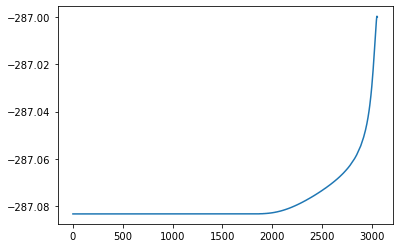

In [215]:
# plt.plot(nav_lon[:,0])
# print(np.max(nav_lon[:,-1])+np.min(nav_lon[:,0])/2)

In [185]:
# lon_shift = np.zeros((len(nav_lat[:,0]),len(nav_lat[0,:])))
# for ii in range(len(nav_lat[:,0])):
#     f = nav_lon[ii,0]
#     lon1 = nav_lon[ii,:]
#     ind = np.where(lon1>=f)[0]
#     lon_shift[ii,:] = nav_lon[ii,:]
#     lon_shift[ii,ind] = nav_lon[ii,ind]-360
    
#     #lon_shift[ii,:] = lon1.where(lon1>=f,lon1-360)
    